In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import gc

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2023_06_12_tea_seq_atac_processing/")

path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

In [2]:
## Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))

In [3]:
new_cluster_order = pd.read_csv("/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/data/2021_11_mouse_optimized_cite_seq/processed_files/"\
    "r7_cluster_order_kf_2024_01.csv")
map_r7_to_lv3 = pd.Series(\
    new_cluster_order["Level 3"].values,
    index=new_cluster_order["Cluster"].values)
map_lvl3_to_order = pd.Series(\
    new_cluster_order["Order"].values,
    index=new_cluster_order["Level 3"].values)
map_r7_to_replace_dash = pd.Series(\
    new_cluster_order["Cluster"].values,
    index=[i.replace("-", "_") for i in new_cluster_order["Cluster"].values])
new_cluster_order

Cluster     Group  Old_order           CITE-to-TEA  Order  \
0           LT-HSC_Mllt3      HSCP          1          LT-HSC_Mllt3    1.0   
1                 ST-HSC      HSCP          2                ST-HSC    2.0   
2               MPP4-Hlf      HSCP          3              MPP4-Hlf    3.0   
3              MPP5-Egr1      HSCP          8             MPP5-Egr1    4.0   
4              MPP5-Flt3      HSCP          7             MPP5-Flt3    5.0   
..                   ...       ...        ...                   ...    ...   
83                  ILC2       ILC         84                  ILC2   84.0   
84   Bcl11b+_preETP_Cd3d       ILC         85   Bcl11b+_preETP_Cd3d   85.0   
85  Bcl11b+_preETP_Tdrd5       ILC         88  Bcl11b+_preETP_Tdrd5   86.0   
86         ILC1-ILC3-NKP       ILC         87         ILC1-ILC3-NKP   87.0   
87               MEP-UNK  MultiLin         22               MEP-UNK    NaN   

     Level 1 Level 2            Level 3 Level Kairavee  
0       HSPC     HSC               qHSC            HSC  
1       HSPC     HSC               aHSC            HSC  
2       HSPC    MPP4             HSC-Ly           HSPC  
3       HSPC    MPP5           MPP5-IER       MPP5-IER  
4       HSPC    MPP5          MPP5 Ly-I           HSPC  
..       ...     ...                ...            ...  
83       ILC     ILC               ILC2            ILC  
84    T cell  preETP  pre-ILC1-ILC3-NKP         preETP  
85    T cell  preETP            pre-NKP         preETP  
86       ILC     ILC      ILC1-ILC3-NKP            ILC  
87  MultiLin     MEP            MEP-UNK            NaN  

[88 rows x 9 columns]

In [4]:
# Seqlet annotation
seqlets = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_anno.fea")

# Seqlets
dp_scores = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_dp_scores.fea")
dp_scores = dp_scores.set_index("index").astype(np.float32)
dp_scores = dp_scores.rename(map_r7_to_replace_dash.to_dict(), axis=1)
dp_scores = dp_scores.rename(map_r7_to_lv3.to_dict(), axis=1)

In [5]:
# Load CITE-seq data (SoupX 0.15 corrected)
path_to_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

cite_adata = anndata.read_h5ad(os.path.join(\
    path_to_cite_data,
    "cite_seq_adata_rna_combined_SoupX_0_15_with_R7_clusters.h5ad"))

cite_adata.X = np.log2((10000 * (cite_adata.X.T / \
    cite_adata.X.sum(axis=1).T).T) + 1)

cite_adata.obs["lvl3"] = cite_adata.obs["R7"].replace(\
    map_r7_to_lv3.to_dict()).values
cite_adata.obs["cluster_order"] = cite_adata.obs["lvl3"].replace(\
    map_lvl3_to_order.to_dict()).values

cite_adata = cite_adata[\
    cite_adata.obs.loc[cite_adata.obs["lvl3"] != "MEP-UNK"].sort_values(\
        by="cluster_order").index.values,
    :]

cite_df = pd.DataFrame(\
    cite_adata.X,
    index=cite_adata.obs.index.values,
    columns=cite_adata.var.index.values)

cite_rna = cite_df.copy()
cite_rna["cluster"] = cite_adata.obs.loc[\
    cite_rna.index.values, "lvl3"].values
cite_rna = pd.pivot_table(cite_rna, index="cluster", aggfunc=np.mean)

In [6]:
### Read in the results from previous analysis of seqlet to gene expression cor
## Gene clusters: hierarchical clusturing across seqlet to gene r values
# Read in the gene clusters
gene_clusters = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_gene_clusters.csv",
    header=None, index_col=0)
gene_clusters.index.name = None
## Seqlet clusters: MarkerFinder to hierarchical gene clusters
# Read in the seqlet clusters
marker_df = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_seqlet_markerfinder.csv")

marker_df["pattern"] = seqlets.loc[marker_df["seqlet_idx"].values, "pattern"].values

In [7]:
# Recalculate corr df based on gene clusters and filtered seqlets
cor_df = pearson_corr_df_to_df(\
    cite_rna.loc[\
        dp_scores.columns.values,
        gene_clusters.index.values],
    dp_scores.loc[\
        marker_df["seqlet_idx"].values,:].T)

In [8]:
# Read in pattern Cisbp2 annotations
cbp_anno = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "scan_modisco_pwms/annotate_modisco_pos_patterns_with_cisbp2.fea")

# Read in Cisbp2 annotation
path_cisbp2 = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/reference/"\
    "cisbp2/Mus_musculus_2020_06_01_11_53_pm/"
cisbp_anno = pd.read_table(os.path.join(\
    path_cisbp2,
    "TF_Information_all_motifs.txt"))
cisbp_anno = cisbp_anno.loc[cisbp_anno["Motif_ID"] != "."]
cisbp_anno = cisbp_anno.loc[~cisbp_anno["Motif_ID"].duplicated().values]
map_motif_id_to_fam = pd.Series(\
    cisbp_anno["Family_Name"].values,
    index=cisbp_anno["Motif_ID"].values)

# Map the patterns to the tf-families
pat_to_fam = pd.Series(\
    cbp_anno["match0"].replace(map_motif_id_to_fam).values,
    index=[i.replace("pattern", "pos_pattern") for i in cbp_anno["pattern_id"].values])


pat_to_fam

HSCP_ERP1__pos_pattern_0        C2H2 ZF
HSCP_ERP1__pos_pattern_1           bHLH
HSCP_ERP1__pos_pattern_2        C2H2 ZF
HSCP_ERP1__pos_pattern_3       CBF/NF-Y
HSCP_ERP1__pos_pattern_4            Ets
                               ...     
IG2_MP__pos_pattern_23              Ets
IG2_MP__pos_pattern_24         Myb/SANT
IG2_MP__pos_pattern_25          C2H2 ZF
IG2_MP__pos_pattern_26             bZIP
IG2_MP__pos_pattern_27      THAP finger
Length: 1030, dtype: object

In [9]:
tmp_fams = np.array([pat_to_fam[i] if i in pat_to_fam else "Unknown" for i in \
    marker_df["pattern"].values])

tmp_unique_fams = np.unique(tmp_fams)
tmp_unique_fams = [i for i in tmp_unique_fams if i != "Unknown"]

sel_fams_tick_df = []
for tmp_fam in tmp_unique_fams:
    sel_fams_tick_df.append(tmp_fams == tmp_fam)

sel_fams_tick_df = pd.DataFrame(\
    sel_fams_tick_df,
    index=tmp_unique_fams,
    columns=marker_df["seqlet_idx"].values).astype(int)

sel_fams_tick_df = sel_fams_tick_df.loc[\
    (sel_fams_tick_df.sum(axis=1) > 100).values,:]

order_fams = pd.Series(\
    [np.where(sel_fams_tick_df.loc[i] > 0)[0].mean() for i in \
        sel_fams_tick_df.index.values],
    index=sel_fams_tick_df.index.values)

order_fams = order_fams.sort_values()

sel_fams_tick_df = sel_fams_tick_df.loc[order_fams.index.values]
sel_fams_tick_df

14827692  1345742   15625203  15137609  1012741   1345311   \
Ets                 0         0         0         0         0         0   
RFX                 0         0         0         0         0         0   
THAP finger         0         0         0         0         0         0   
IRF                 0         0         0         0         0         0   
SMAD                0         0         0         0         0         0   
Runt                0         0         0         0         0         0   
C2H2 ZF             1         0         0         0         0         1   
E2F                 0         0         0         0         0         0   
bZIP                0         1         1         1         1         0   
DM                  0         0         0         0         0         0   
bHLH                0         0         0         0         0         0   
CBF/NF-Y            0         0         0         0         0         0   
GATA                0         0         0         0         0         0   

             12309819  7028078   8564852   14158105  ...  7476821   9020813   \
Ets                 1         0         0         0  ...         0         0   
RFX                 0         0         0         0  ...         0         0   
THAP finger         0         0         0         0  ...         0         0   
IRF                 0         0         0         0  ...         0         0   
SMAD                0         0         0         0  ...         0         0   
Runt                0         0         0         0  ...         0         0   
C2H2 ZF             0         0         0         0  ...         0         0   
E2F                 0         0         0         0  ...         0         0   
bZIP                0         1         1         1  ...         0         0   
DM                  0         0         0         0  ...         0         0   
bHLH                0         0         0         0  ...         1         1   
CBF/NF-Y            0         0         0         0  ...         0         0   
GATA                0         0         0         0  ...         0         0   

             421547    13068027  651754    7476822   729144    13332530  \
Ets                 0         0         1         0         0         0   
RFX                 0         0         0         0         0         0   
THAP finger         0         0         0         0         0         0   
IRF                 0         0         0         0         0         0   
SMAD                0         0         0         0         0         0   
Runt                0         0         0         0         0         0   
C2H2 ZF             0         0         0         1         0         0   
E2F                 0         0         0         0         0         0   
bZIP                0         0         0         0         0         1   
DM                  0         0         0         0         0         0   
bHLH                1         1         0         0         1         0   
CBF/NF-Y            0         0         0         0         0         0   
GATA                0         0         0         0         0         0   

             13250720  8694576   
Ets                 0         0  
RFX                 0         0  
THAP finger         0         0  
IRF                 0         0  
SMAD                0         0  
Runt                0         0  
C2H2 ZF             1         1  
E2F                 0         0  
bZIP                0         0  
DM                  0         0  
bHLH                0         0  
CBF/NF-Y            0         0  
GATA                0         0  

[13 rows x 80441 columns]

In [10]:
marker_df

seqlet_idx         r  gene_cluster                         pattern
0        14827692  0.167123             5  pre_MultiLin_2__pos_pattern_13
1         1345742  0.166701             5       CLP1_Rrm2__pos_pattern_21
2        15625203  0.166565             5        proNeu_1__pos_pattern_20
3        15137609  0.166530             5  pre_MultiLin_2__pos_pattern_19
4         1012741  0.166284             5        CD127_MP__pos_pattern_21
...           ...       ...           ...                             ...
80436     7476822  0.115280           169     IG2_proNeu1__pos_pattern_16
80437      729144  0.113351           169            BMCP__pos_pattern_14
80438    13332530  0.112835           169   MultiLin_1_MEP__pos_pattern_8
80439    13250720  0.106876           169  MultiLin_1_MEP__pos_pattern_19
80440     8694576  0.106090           169        MDP_Cpa3__pos_pattern_26

[80441 rows x 4 columns]

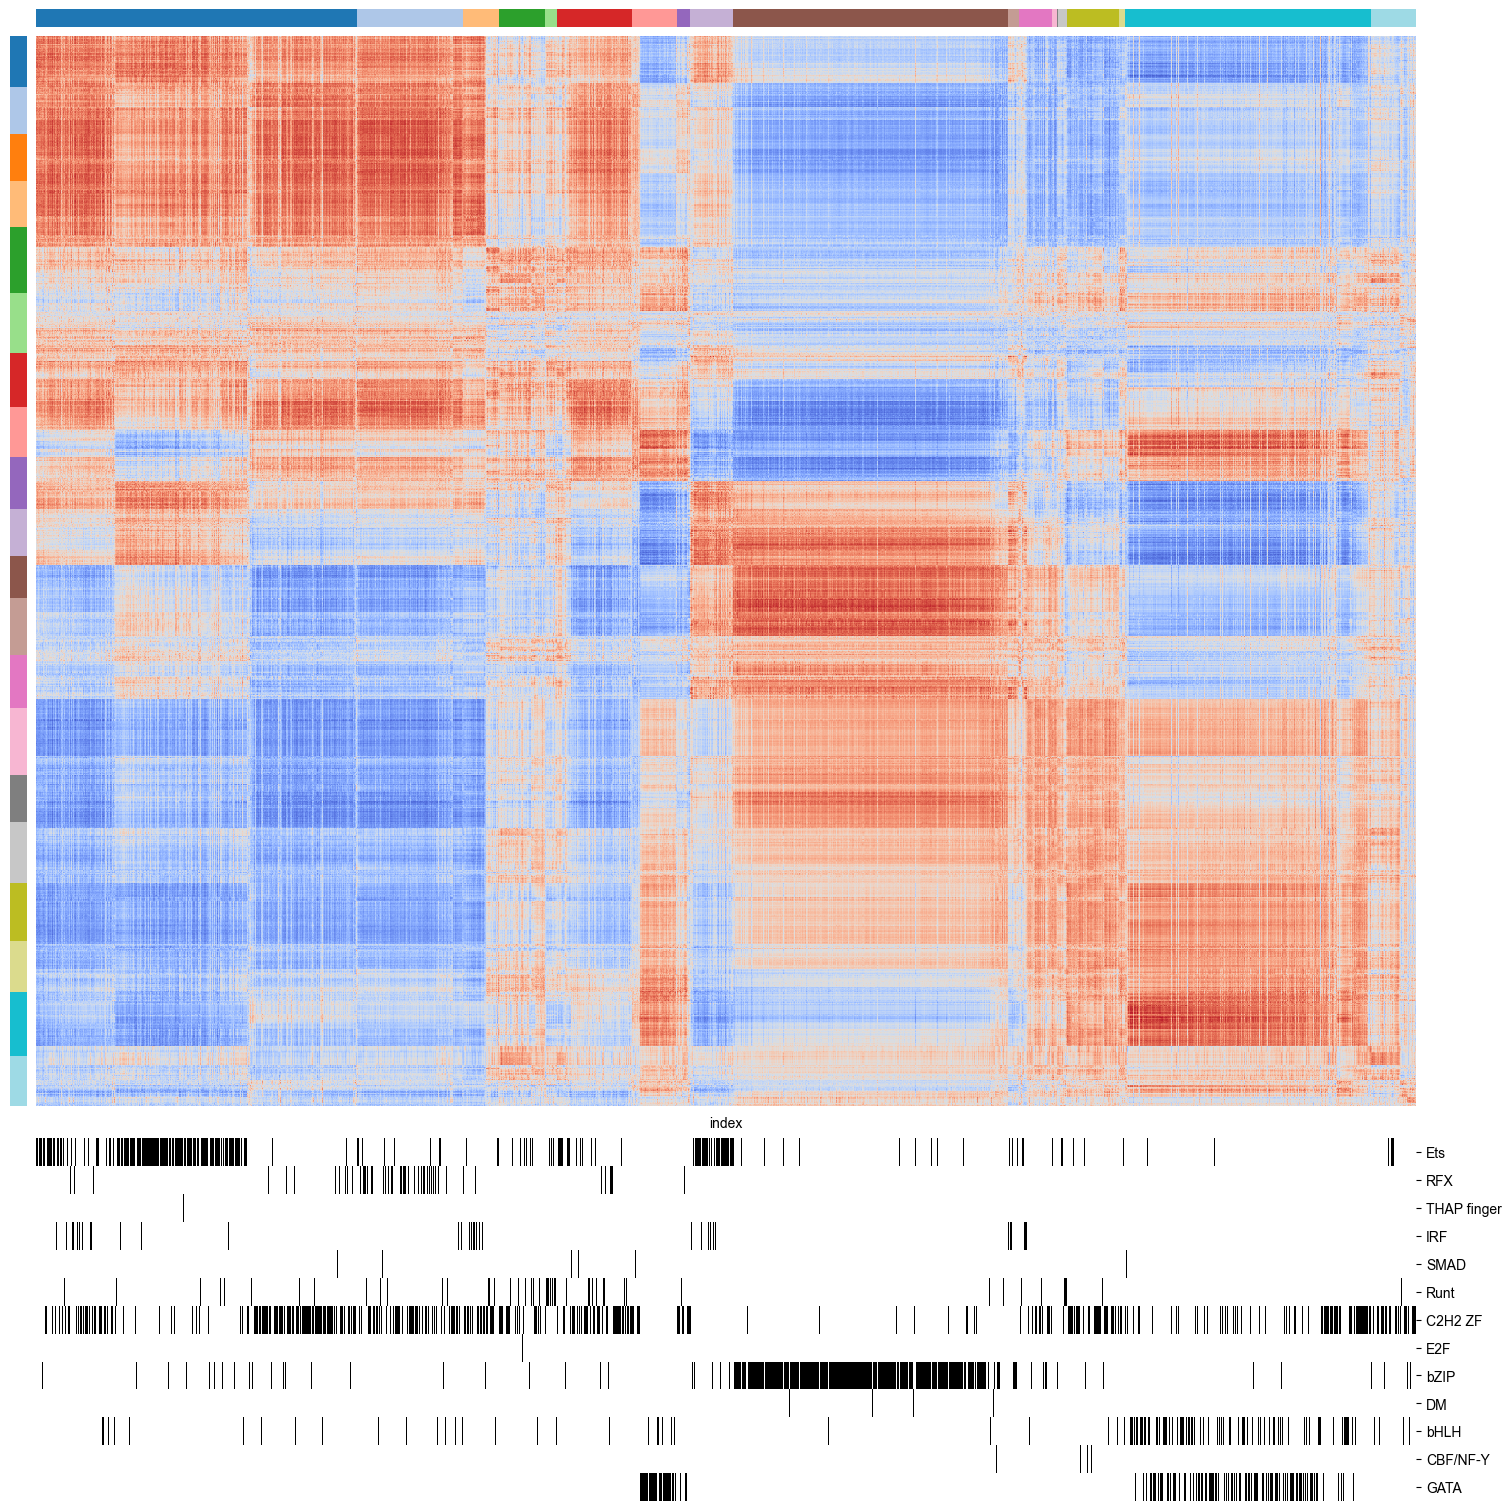

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(15,15))
ax = fig.add_gridspec(80, 80)
ax1 = fig.add_subplot(ax[1:60, 0])
ax2 = fig.add_subplot(ax[0, 1:])
ax3 = fig.add_subplot(ax[1:60, 1:])
ax4 = fig.add_subplot(ax[60:, 1:])

rowClusters = sns.heatmap(gene_clusters[[1]].astype(np.float32),
                        cmap="tab20",
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

colClusters = sns.heatmap(marker_df[["gene_cluster"]].T.astype(np.float32),
                        cmap="tab20",
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax2)

heat1 = sns.heatmap(cor_df, 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=ax3,
    rasterized=True)

heat3 = sns.heatmap(sel_fams_tick_df,
    cmap="Greys",
    yticklabels=True,
    xticklabels=False,
    cbar=False,
    ax=ax4,
    rasterized=True)
ax4.yaxis.tick_right()
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, ha='left')

plt.savefig("output/FINAL_FIGURES_DIR/gene_seqlet_corr_with_families_low_gene_exp_threshold.pdf")